# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [41]:
import pandas as pd
import numpy as np

---
## 2. Load data

In [42]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [43]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [44]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [45]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


Now it is time to get creative and to conduct some of your own feature engineering! Have fun with it, explore different ideas and try to create as many as you can!

---
# Basic Extraction

### 3-1. Price Difference Between Dec and Jan

In [46]:
# 1. 가격 데이터에서 '1월'과 '12월' 데이터만 뽑아내기 대신,
# 각 고객(id)별로 가격 변동폭을 계산하는 로직입니다.

# id와 price_date를 기준으로 정렬
price_df_sorted = price_df.sort_values(['id', 'price_date'])

# 각 id별로 가장 마지막 달(12월)과 첫 달(1월)의 가격 차이를 구하기 위한 피벗팅
# 여기서는 간단하게 'off_peak'(비피크 시간대) 가격만 예시로 봅니다.
price_chunk = price_df_sorted.groupby(['id']).agg({
    'price_off_peak_var': ['last', 'first'], # 12월(last)과 1월(first) 값 가져오기
    'price_off_peak_fix': ['last', 'first']
}).reset_index()

# 컬럼 이름 정리
price_chunk.columns = ['id', 'offpeak_dec_var', 'offpeak_jan_var', 'offpeak_dec_fix', 'offpeak_jan_fix']

# 2. 변동폭(Difference) 계산: 12월 가격 - 1월 가격
price_chunk['offpeak_diff_dec_january_energy'] = price_chunk['offpeak_dec_var'] - price_chunk['offpeak_jan_var']
price_chunk['offpeak_diff_dec_january_power'] = price_chunk['offpeak_dec_fix'] - price_chunk['offpeak_jan_fix']

# 필요한 컬럼만 남기기
diff = price_chunk[['id', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power']]

print("가격 변동 변수 생성 완료!")
diff.head()

가격 변동 변수 생성 완료!


,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


### 3-2.충성도(Tenure) 계산

In [47]:
# 가입 기간(Tenure) 계산 공식: (종료 연도 - 가입 연도) * 12 + (종료 월 - 가입 월)
# 이렇게 하면 총 '개월 수'가 나옵니다.
df['tenure'] = ((df['date_end'].dt.year - df['date_activ'].dt.year) * 12 + 
                (df['date_end'].dt.month - df['date_activ'].dt.month))

print("가입 기간(Tenure) 변수 생성 완료!")
# 잘 만들어졌는지 상위 5개 확인
df[['date_activ', 'date_end', 'tenure']].head()

가입 기간(Tenure) 변수 생성 완료!


,date_activ,date_end,tenure
0,2013-06-15,2016-06-15,36
1,2009-08-21,2016-08-30,84
2,2010-04-16,2016-04-16,72
3,2010-03-30,2016-03-30,72
4,2010-01-13,2016-03-07,74


### 3-3. Encoding for Computer

In [48]:
# 1. 'has_gas' 컬럼: t(True) -> 1, f(False) -> 0으로 변환
df['has_gas'] = df['has_gas'].replace({'t': 1, 'f': 0})

# 2. 'channel_sales' (영업 경로): 범주형 데이터 -> One-hot Encoding
# 예: channel_A, channel_B 컬럼이 새로 생기고 해당하면 1, 아니면 0이 됨
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')

# 3. 'origin_up' (최초 가입 캠페인): 마찬가지로 One-hot Encoding
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin')

# 팁: 불필요한 id 컬럼 등을 제외하고, 학습에 방해되는 문자열 컬럼 삭제
# (날짜 컬럼들은 이제 tenure를 만들었으니 모델 학습 시에는 뺄 수도 있습니다)
print("범주형 데이터 인코딩 완료!")
df.head()

범주형 데이터 인코딩 완료!


,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_sddiedcslfslkckwlfkdpoeeailfpeds,channel_usilxuppasemubllopkaafesmlibmsdf,origin_MISSING,origin_ewxeelcelemmiwuafmddpobolfuxioce,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw,origin_usapbepcfoloekilkwsdiboslwaxobdp
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,1,0,0,0,0,0,0,0,1,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,0,0,0,0,0,0,1,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,1,0,0,0,0,0,1,0,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,0,1,0,0,0,0,1,0,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,0,0,0,0,0,0,1,0,0,0


## Basic Final Merge

In [49]:
# 고객 데이터(df)에 가격 변동 데이터(diff)를 'id' 기준으로 합치기
# how='left'는 고객 데이터는 하나도 잃어버리지 않고, 매칭되는 가격 정보만 붙이겠다는 뜻
train_df = pd.merge(df, diff, on='id', how='left')

print("최종 데이터셋 완성!")
print(train_df.shape) # 행과 열의 개수 확인
train_df.head()

최종 데이터셋 완성!
(14606, 59)


,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,channel_sddiedcslfslkckwlfkdpoeeailfpeds,channel_usilxuppasemubllopkaafesmlibmsdf,origin_MISSING,origin_ewxeelcelemmiwuafmddpobolfuxioce,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw,origin_usapbepcfoloekilkwsdiboslwaxobdp,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,0,0,0,0,0,0,1,0,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,0,0,0,0,1,0,0,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,0,0,0,0,1,0,0,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,0,0,0,0,1,0,0,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,0,0,0,0,1,0,0,0,-0.006192,0.162916


---
# Upper Level Extraction

### 4-1.Volatility
#### 가격의 균형도를 맞추기 위함.

In [50]:
# 가격 데이터(price_df)를 사용합니다.
# 각 고객(id)별로 가격의 '표준편차(std)'와 '평균(mean)'을 한 번에 계산합니다.
price_stats = price_df.groupby(['id']).agg({
    'price_off_peak_var': ['mean', 'std'],
    'price_off_peak_fix': ['mean', 'std']
}).reset_index()

# 컬럼 이름이 2단으로 되어 있어서 깔끔하게 정리해줍니다.
price_stats.columns = ['id', 'avg_price_energy', 'std_price_energy', 'avg_price_power', 'std_price_power']

# 결과 확인: std 값이 클수록 가격 변동이 심했던 고객입니다.
price_stats.head()

# (나중에 이 price_stats를 train_df에 merge로 합쳐야 합니다)

,id,avg_price_energy,std_price_energy,avg_price_power,std_price_power
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.003976,40.701732,6.341481e-02
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.002197,44.385450,8.753223e-02
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.026008,45.319710,7.723930e-01
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.005049,40.647427,8.507958e-02
4,00114d74e963e47177db89bc70108537,0.147926,0.002202,44.266930,5.908392e-07


### 4-2.Intersection Below

In [57]:
# 먼저 위에서 만든 price_stats를 원본 데이터(df)에 합칩니다.
df = pd.merge(df, price_stats, on='id', how='left')

# 파생 변수 생성: 사용량(cons_12m) * 평균 가격(avg_price_energy)
# 주의: 정확한 청구서는 아니지만, '청구 금액의 규모'를 나타내는 강력한 변수가 됩니다.
df['estimated_bill'] = df['cons_12m'] * df['avg_price_energy']

# 로그 변환: 금액은 단위가 너무 크므로 로그를 씌워주는 것이 모델 학습에 좋습니다.
df['log_estimated_bill'] = np.log1p(df['estimated_bill'])

print("예상 청구 금액 변수 생성 완료!")
df[['cons_12m', 'avg_price_energy', 'estimated_bill']].head()

예상 청구 금액 변수 생성 완료!


,cons_12m,avg_price_energy,estimated_bill
0,0,0.124787,0.000000
1,4660,0.149609,697.177552
2,544,0.170512,92.758347
3,1584,0.151210,239.516772
4,4425,0.124174,549.471425


### 4-3.Short Term & Long Term

In [52]:
# 날짜 기준으로 내림차순 정렬 (최신 날짜가 위로 오게)
price_df_sorted = price_df.sort_values(['id', 'price_date'], ascending=[True, False])

# 각 id별로 상위 3개(최근 3개월)만 뽑아서 평균 내기
last_3_months_avg = price_df_sorted.groupby('id').head(3).groupby('id')['price_off_peak_var'].mean().reset_index()
last_3_months_avg.columns = ['id', 'recent_3m_avg_price']

# 아까 만든 전체 평균(price_stats)과 합쳐서 비교
trend_df = pd.merge(price_stats[['id', 'avg_price_energy']], last_3_months_avg, on='id')

# "최근 가격이 1년 평균 대비 몇 %나 비싼가?" (Ratio)
trend_df['price_trend_ratio'] = trend_df['recent_3m_avg_price'] / trend_df['avg_price_energy']

# 1.0보다 크면 최근에 가격이 오른 것이고, 작으면 내린 것입니다.
print("가격 추세 변수 생성 완료!")
trend_df.head()

가격 추세 변수 생성 완료!


,id,avg_price_energy,recent_3m_avg_price,price_trend_ratio
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.119906,0.964352
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.143943,0.983039
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.201280,1.108623
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.113068,0.952095
4,00114d74e963e47177db89bc70108537,0.147926,0.145440,0.983195


컬럼 정리 완료! 깔끔해진 목록 확인:
Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'date_activ',
       'date_end', 'date_modif_prod', 'date_renewal', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max',
       'var_year_price_off_peak_var', 'var_year_price_peak_var',
       'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix',
       'var_year_price_peak_fix', 'var_year_price_mid_peak_fix',
       'var_year_price_off_peak', 'var_year_price_peak',
       'var_year_price_mid_peak', 'var_6m_price_off_peak_var',
       'var_6m_price_peak_var', 'var_6m_price_mid_peak_var',
       'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix',
       'var_6m_price_mid_peak_fix', 'var_6m_price_off

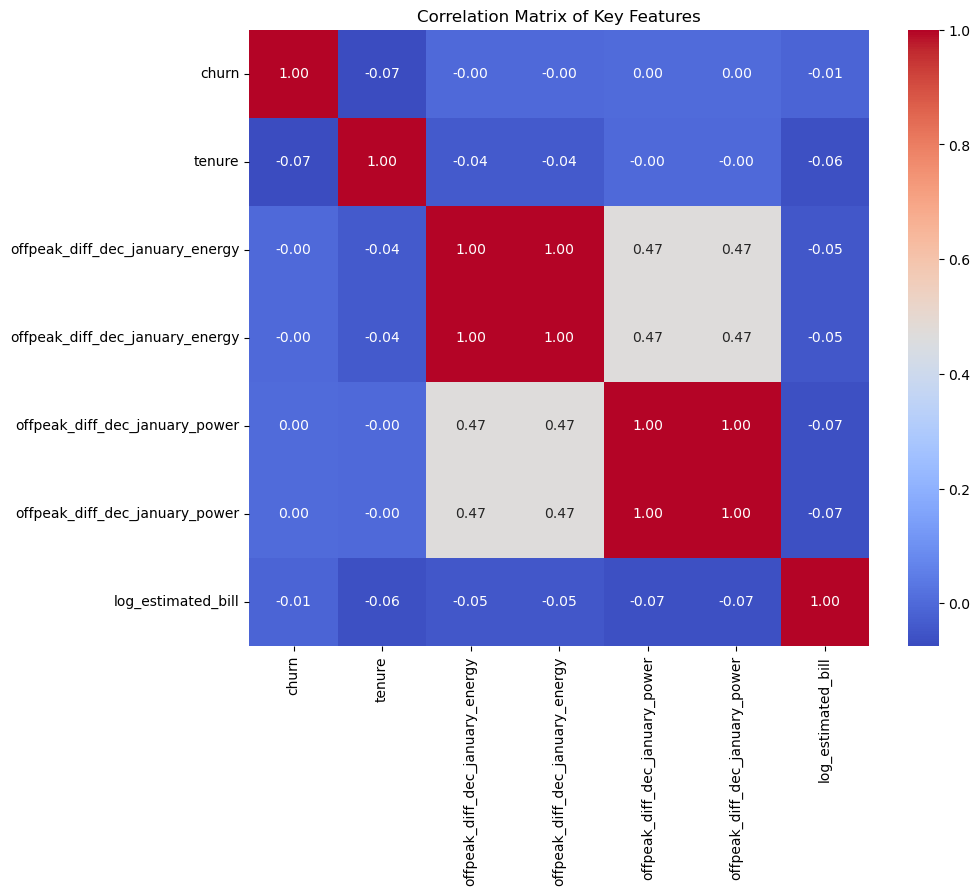

In [64]:
# 1. 이름이 꼬인 컬럼들을 정리합시다.
# '_x'가 붙은 컬럼(원본 데이터)을 다시 원래 깔끔한 이름으로 되돌립니다.
train_df = train_df.rename(columns={
    'offpeak_diff_dec_january_energy_x': 'offpeak_diff_dec_january_energy',
    'offpeak_diff_dec_january_power_x': 'offpeak_diff_dec_january_power'
})

# 2. 이제 필요 없어진 중복 컬럼들(이름에 _x, _y가 들어간 것들)을 다 삭제합니다.
# (깔끔한 csv 저장을 위해서도 필요합니다)
cols_to_drop = [c for c in train_df.columns if c.endswith('_x') or c.endswith('_y')]
train_df = train_df.drop(columns=cols_to_drop)

print("컬럼 정리 완료! 깔끔해진 목록 확인:")
print(train_df.columns)

# 3. 다시 상관관계 분석 실행 (이제 에러가 안 날 겁니다)
import seaborn as sns
import matplotlib.pyplot as plt

cols_to_check = ['churn', 'tenure', 'offpeak_diff_dec_january_energy', 
                 'offpeak_diff_dec_january_power', 'log_estimated_bill']

corr = train_df[cols_to_check].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Key Features")
plt.show()

# 4. 정리된 최종 파일 저장 (이걸로 제출하시면 됩니다)
train_df.to_csv('clean_data_with_features.csv', index=False)